
##### Dhia Elhak EZZEDDINI 
##### dhiaelhak.ezzeddini@supcom.tn
CopyRight Information
##### © MIT 6.S191: Introduction to Deep Learning
##### http://introtodeeplearning.com

In [ ]:
!pip install comet_ml

In [22]:
import comet_ml
COMET_API_KEY = "eCllTwbltsuTdqcCgNTak6Uj2"
import torch
import torch.nn as nn
import torch.optim as optim
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [ ]:
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import  tqdm
from scipy.io.wavfile import write
!apt-get install abcmidi timidity 
torch.cuda.is_available()

In [ ]:
!pip install mitdeeplearning --quiet

import mitdeeplearning as mdl

In [25]:
assert torch.cuda.is_available(), "Please enable GPU from runtime settings"
assert COMET_API_KEY != "", "Please Provide your COMET API key"

In [26]:

songs_dataset = mdl.lab1.load_training_data()

ex = songs_dataset[0]
print("\nexample song : ")
print(ex)


Found 817 songs in text

example song : 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [ ]:
# Playing the first song in the Dataset
mdl.lab1.play_song(ex)

In [28]:
## Joining all songs into a single string
all_songs = "\n\n".join(songs_dataset)

## finding all unique characters in the joined list
vocab = sorted(set(all_songs))
print(len(vocab) , "unique characters in the dataset")

83 unique characters in the dataset


sequence of characters ==> RNN Model ==> Output : next character at each time step


Text Vectorization :

In [29]:
### defining a numerical representation of the text ###

# creating a mapping from character to index #

char2idx = {u: i for i,u in enumerate(vocab)} # ==> integer representation of each character

# creating a mapping from character to index #

idx2char = np.array(vocab)

In [30]:

## visualizing the character mapping
print('{')
for char, _ in zip(char2idx, range(20)) :
  print(' {:4s} : {:3d},'.format(repr(char),char2idx[char]))
print(' ...\n')


{
 '\n' :   0,
 ' '  :   1,
 '!'  :   2,
 '"'  :   3,
 '#'  :   4,
 "'"  :   5,
 '('  :   6,
 ')'  :   7,
 ','  :   8,
 '-'  :   9,
 '.'  :  10,
 '/'  :  11,
 '0'  :  12,
 '1'  :  13,
 '2'  :  14,
 '3'  :  15,
 '4'  :  16,
 '5'  :  17,
 '6'  :  18,
 '7'  :  19,
 ...



In [31]:
### Vectorizing the songs strings ###

def Vectorizing_string(string) :
  n = len(string)
  l = []
  for char in string :
    num = char2idx[char]
    l.append(num)
  nparray = np.array(l,dtype=int)
  return nparray
assert isinstance(Vectorizing_string(ex), np.ndarray) , "returned result should be a numpy array"


In [32]:

vectorized_songs = Vectorizing_string(all_songs)
print('{} ------ characters mapped to int -------> {}'.format(repr(all_songs[:20]),vectorized_songs[:20]))
print(vectorized_songs[0:100])
print(len(vectorized_songs))

"X:1\nT:Alexander's\nZ:" ------ characters mapped to int -------> [49 22 13  0 45 22 26 67 60 79 56 69 59 60 73  5 74  0 51 22]
[49 22 13  0 45 22 26 67 60 79 56 69 59 60 73  5 74  0 51 22  1 64 59 22
 59 58  9 63 70 73 69 71 64 71 60  9 13  0 38 22 28 82  0 37 22 13 11 20
  0 36 22 29  1 38 56 65 70 73  0  6 15 26 27 58 82 59 26 31 26  1 29 31
 26 59 82 61 59 58 59  1 31 26 59 61 82 62 61 62 60  1 61 60 61 59 82  6
 15 60 61 60]
200679


In [71]:
import random

def augment_token_stream(tokens, num_segments=4):
    """
    Augments a single long token sequence by slicing, reversing, and shuffling.

    Args:
        tokens (list[int]): The full token stream.
        num_segments (int): How many segments to divide into.

    Returns:
        list[int]: Augmented token stream.
    """
    if num_segments < 2 or len(tokens) < num_segments:
        return tokens  # Not enough tokens

    segment_len = len(tokens) // num_segments
    segments = [tokens[i*segment_len : (i+1)*segment_len] for i in range(num_segments)]

    # Add any leftover tokens to the last segment
    leftover = tokens[num_segments * segment_len:]
    if leftover :
        segments[-1].extend(leftover)

    # Reverse some segments randomly
    segments = [seg[::-1] if random.random() < 0.5 else seg for seg in segments]

    # Shuffle segment order
    random.shuffle(segments)

    # Flatten and return
    return [token for seg in segments for token in seg]


augmented_song = augment_token_stream(vectorized_songs.tolist())

for i in vectorized_songs : 
    augmented_song.append(i)
    
augmented_song = augment_token_stream(vectorized_songs.tolist())



In [72]:
train_songs = vectorized_songs[0:int(len(vectorized_songs)*0.7)]
val_songs = vectorized_songs[int(len(vectorized_songs)*0.7):int(len(vectorized_songs))]

  Creating training examples and targets

In [35]:
## Batch function definition to create training examples ##

def get_batch(vectorized_songs , seq_len, batch_size) :
  n = len(vectorized_songs) - 1
  #print(n)
  idx = np.random.choice(n - seq_len , batch_size)
  #print(idx)
  ## list of input sequences making the batch
  input_batch =  [vectorized_songs[i : i + seq_len] for i in idx]
  ## list of target sequences corresponding to the input sequences
  output_batch = [vectorized_songs[i+1 : i + seq_len+1] for i in idx]

  ## converting the input and output lists into tensors
  x_batch  = torch.tensor(input_batch,dtype=torch.long)
  y_batch  = torch.tensor(output_batch,dtype=torch.long)

  return x_batch , y_batch

In [66]:
### Testing the get_batch function :
test_args = (vectorized_songs,10,2)
x_batch , y_batch = get_batch(*test_args)
assert x_batch.shape == (2, 10), "x_batch shape is incorrect"
assert y_batch.shape == (2, 10), "y_batch shape is incorrect"
print("Batch function works correctly!")
print(x_batch)
print(y_batch)

Batch function works correctly!
tensor([[32, 31,  1, 29, 31, 11, 29, 11, 82, 28],
        [29, 82, 32, 15,  1, 32, 14, 22, 82,  2]])
tensor([[31,  1, 29, 31, 11, 29, 11, 82, 28, 11],
        [82, 32, 15,  1, 32, 14, 22, 82,  2,  0]])


In [37]:
x_batch,y_batch = get_batch(vectorized_songs,5,1)
print(x_batch)
print(y_batch)
for i ,(input_idx,target_idx) in enumerate(zip(x_batch[0],y_batch[0])) :
  print("Step {:3d}".format(i))
  print(" input: {} ({:s})".format(input_idx,repr(idx2char[input_idx.item()])))
  print("  expected output : {} ({:s})".format(target_idx , repr(idx2char[target_idx.item()])))

tensor([[45, 22, 29, 70, 69]])
tensor([[22, 29, 70, 69, 60]])
Step   0
 input: 45 ('T')
  expected output : 22 (':')
Step   1
 input: 22 (':')
  expected output : 29 ('D')
Step   2
 input: 29 ('D')
  expected output : 70 ('o')
Step   3
 input: 70 ('o')
  expected output : 69 ('n')
Step   4
 input: 69 ('n')
  expected output : 60 ('e')


Recurrent Neural Network Model

In [38]:
## Defining the RNN Model ##
class LSTMModel(nn.Module):

  def __init__(self,vocab_size,embedding_dim,hidden_size) :
    super(LSTMModel,self).__init__()
    self.hidden_size = hidden_size

    #### defining each of the network layers :

    # Embedding layer : transform indices into dense vectors of a fixed embedding size
    self.embedding = nn.Embedding(vocab_size,embedding_dim)

    # LSTM layer
    self.lstm = nn.LSTM(embedding_dim,hidden_size,batch_first=True)

    # Linear layer : fully connected ==> transforms LSTM output into the vocabulary
    self.fc=nn.Linear(hidden_size,vocab_size)


  def init_hidden(self,batch_size,device) :
    return (torch.zeros(1,batch_size,self.hidden_size).to(device),
           (torch.zeros(1,batch_size,self.hidden_size).to(device)))


  def forward(self , x , state=None , return_state=False) :
    x = self.embedding(x)
    if state is None :
      state = self.init_hidden(x.size(0),x.device)
    out,state=self.lstm(x,state)
    out = self.fc(out)
    return out if not return_state else (out,state)

In [39]:
### Initializing the model

vocab_size = len(vocab)
embedding_dim = 256
hidden_size=1024
batch_size=8


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = LSTMModel(vocab_size,embedding_dim,hidden_size).to(device)

## summary of the model
print(model)


LSTMModel(
  (embedding): Embedding(83, 256)
  (lstm): LSTM(256, 1024, batch_first=True)
  (fc): Linear(in_features=1024, out_features=83, bias=True)
)


In [40]:
### Testing out the model

x,y = get_batch(vectorized_songs,50,32)
x = x.to(device)
y = y.to(device)
pred = model(x)

print("Input shape     :  ",x.shape ,"      # (batch_size,sequence_length)")
print("Predection size :  ",pred.shape,"  # (batch_size,sequence_length,vocab_size)")


Input shape     :   torch.Size([32, 50])       # (batch_size,sequence_length)
Predection size :   torch.Size([32, 50, 83])   # (batch_size,sequence_length,vocab_size)


In [41]:
sampled_indices = torch.multinomial(torch.softmax(pred[0],dim=-1),num_samples=1)
sampled_indices = sampled_indices.squeeze(-1).cpu().numpy()
sampled_indices

array([18,  8, 43, 78, 13, 12, 42, 18,  5, 30, 78, 59, 53, 37, 36, 25, 66,
        5,  0, 55, 53, 62, 32, 64, 27, 33, 80, 78,  4, 49, 67, 35, 82, 27,
       73, 10, 17, 30,  8, 38, 30, 33, 70, 36, 80, 63, 73,  5, 32, 58])

In [42]:
print("Input: \n",repr(("".join(idx2char[x[0].cpu()]))))
print()
print("Next Char Predections: \n",repr("".join(idx2char[sampled_indices]))) 

Input: 
 'd2 f2|e4 d2|!\nde fg a2|a2 b2 g2|f3 g e2|d4 f2|gf e'

Next Char Predections: 
 "6,Rw10Q6'Ewd]LK>k'\n_]gGiBHyw#XlJ|Br.5E,MEHoKyhr'Gc"


Training the Network

In [43]:
### Defining the loss function ###

cross_entropy = nn.CrossEntropyLoss()
def compute_loss(labels,logits) :
  batched_labels = labels.view(-1)
  batched_logits = logits.view(-1,logits.shape[-1])
  loss = cross_entropy(batched_logits,batched_labels)

    
  return loss

In [44]:

ex_batch_loss = compute_loss(y,pred)

print(f"Prediction shape: {pred.shape} # (batch_size, sequence_length, vocab_size)")
print(f"scalar_loss: {ex_batch_loss.mean().item()}")

Prediction shape: torch.Size([32, 50, 83]) # (batch_size, sequence_length, vocab_size)
scalar_loss: 4.416324615478516


In [57]:
### Hyperparameter setting and optimization ###

vocab_size = len(vocab)

## Model parameters :
params = dict(
    num_training_iter  = 7000,
    batch_size = 8 ,
    seq_len = 100,
    learning_rate = .005,
    embedding_dim = 256 ,
    hidden_size = 1024
)

# checkpoints location  :
check_dir ="./training_checkpoints"
checkpoint_prefix = os.path.join(check_dir,"my_ckpt")
os.makedirs(check_dir,exist_ok=True)


In [46]:
##### Creating a Comet experiment to track our training run
def create_exp():
  if 'experiment' in locals():
    experiment.end()

  experiment = comet_ml.Experiment(
      api_key = COMET_API_KEY,
      project_name = "Music_Gen_lab"
      )
  for param , value in params.items() :
    experiment.log_parameter(param , value)
  experiment.flush()
  return experiment

In [47]:
###### adding more features to the code :

## evaluation

def evaluate_model(model,val_data , params) : 
    model.eval()
    val_losses = []
    with torch.no_grad():
        for _ in range(10):
            x_val , y_val = get_batch(val_data,params["seq_len"],params["batch_size"])
            x_val = torch.tensor(x_val , dtype=torch.long).to(device)
            y_val = torch.tensor(y_val , dtype=torch.long).to(device)

            yhat = model(x_val)
            loss = compute_loss(y_val , yhat)
            val_losses.append(loss.item())

    return sum(val_losses)/len(val_losses)
    

In [48]:
class EarlyStopping:
    def __init__(self,patience=5) : 
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
    def step(self,val_loss):
        if val_loss < self.best_loss : 
            self.best_loss = val_loss
            self.counter = 0
        else : 
            self.counter +=1
            if self.counter >= self.patience : 
                self.early_stop = True
    

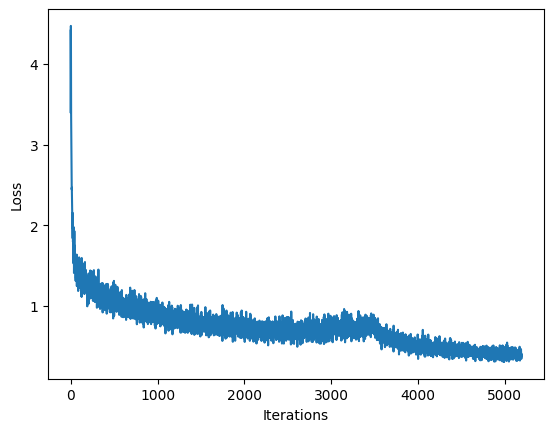

100%|██████████| 875/875 [00:23<00:00, 36.57it/s]


Validation Loss after epoch6:1.6290
Early stopping triggered!


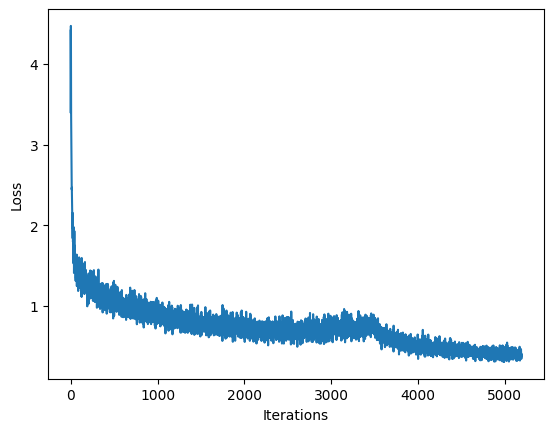

In [73]:
### Defining Optimizer and Training operation ###

model = LSTMModel(vocab_size,params['embedding_dim'],params['hidden_size'])
model.to(device)
optimizer = optim.Adam(model.parameters(),lr=params['learning_rate'])


early_stopper = EarlyStopping(patience=5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5,patience=2,verbose=True)

def train_step(x,y) :
  # model mode to train
  model.train()
  # Zero gradient for each step
  optimizer.zero_grad()
  # Forward pass
  y_hat = model(x)
  # Compute the loss
  loss = compute_loss(y,y_hat)
  # Backward steps
  loss.backward()
  optimizer.step()
  return loss

##########################
#### Start Training ######
##########################

num_epochs = 8
iters_per_epoch = params["num_training_iter"]//num_epochs

hist = []
plotter = mdl.util.PeriodicPlotter(sec=2,xlabel='Iterations',ylabel='Loss')
experiment = create_exp()

if hasattr(tqdm, '_instances') : tqdm._instances.clear()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for iter in tqdm(range(iters_per_epoch)):
        x_batch,y_batch = get_batch(train_songs,params['seq_len'],params['batch_size'])
        x_batch = torch.tensor(x_batch, dtype=torch.long).to(device)
        y_batch = torch.tensor(y_batch, dtype=torch.long).to(device)
        loss = train_step(x_batch,y_batch)
        global_iter = epoch*iters_per_epoch + iter
        experiment.log_metric("loss" ,loss.item(),step=global_iter)

        hist.append(loss.item())
        plotter.plot(hist)

        if global_iter%100==0:
            torch.save(model.state_dict(),checkpoint_prefix)
    val_loss = evaluate_model(model,val_songs,params)
    experiment.log_metric("val_loss", val_loss, step=global_iter)
    print(f"Validation Loss after epoch{epoch +1}:{val_loss:.4f}")
    scheduler.step(val_loss)
    early_stopper.step(val_loss)

    if early_stopper.early_stop:
        print("Early stopping triggered!")
        break

In [ ]:

torch.save(model.state_dict(),checkpoint_prefix)
experiment.flush()
experiment.end()

In [75]:
def generate_text(model, start_string, generation_length=1000):

  input_idx = [char2idx[s] for s in start_string] # TODO
  input_idx = torch.tensor([input_idx], dtype=torch.long).to(device)

  state = model.init_hidden(input_idx.size(0), device)

  text_generated = []
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):

    predictions, state = model(input_idx, state, return_state=True)


    predictions = predictions.squeeze(0)

    input_idx = torch.multinomial(torch.softmax(predictions, dim=-1), num_samples=1)

    text_generated.append(idx2char[input_idx].item()) 


  return (start_string + ''.join(text_generated))






In [76]:
generated_text = generate_text(model,start_string="X",generation_length=1500)

100%|██████████| 1500/1500 [00:01<00:00, 1271.48it/s]


In [ ]:
print(generated_text)

In [ ]:
### Playing back generated song ###

gen_song = mdl.lab1.extract_song_snippet(generated_text)


for i , song in enumerate(gen_song) :
  waveform =  mdl.lab1.play_song(song)
  if waveform :
    print("Generated Song " , i)
    ipythondisplay.display(waveform)
    num_data = np.frombuffer(waveform.data,dtype=np.int16)
    wav_file_path = f"output_{i}.wav"
    write(wav_file_path,88200,num_data)
    experiment.log_asset(wav_file_path)

    


